In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import altair as alt

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain import utils
from plot.scatter import scatter_plot, _get_bounds
from plot.summary import summary_plot

In [3]:
utils.set_up_environment(visible_devices='0')

In [180]:
n = 5000
d = 2
noise = 0.5
X = np.random.randn(n, d) + 5
y = X[:, 0] / X[:, 1]

In [181]:
df = pd.DataFrame({
    'x_0': X[:, 0],
    'x_1': X[:, 1],
    'label': y
})
alt.Chart(df).mark_point(filled=True, opacity=1.0).encode(
    alt.X('x_0:Q'),
    alt.Y('x_1:Q'),
    alt.Color('label:Q')
)

alt.Chart(...)

In [182]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [183]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [184]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 32        
Total params: 2,240
Trainable params: 2,240
Non-trainable params: 0
_________________________________________________________________


In [185]:
learning_rate = 0.05
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [186]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 0s - loss: 3.7519 - val_loss: 0.1555
Epoch 2/20
799/799 - 0s - loss: 0.1526 - val_loss: 0.1248
Epoch 3/20
799/799 - 0s - loss: 0.1251 - val_loss: 0.1033
Epoch 4/20
799/799 - 0s - loss: 0.1046 - val_loss: 0.0815
Epoch 5/20
799/799 - 0s - loss: 0.0856 - val_loss: 0.0644
Epoch 6/20
799/799 - 0s - loss: 0.0687 - val_loss: 0.0459
Epoch 7/20
799/799 - 0s - loss: 0.0474 - val_loss: 0.0380
Epoch 8/20
799/799 - 0s - loss: 0.0303 - val_loss: 0.0289
Epoch 9/20
799/799 - 0s - loss: 0.0197 - val_loss: 0.0247
Epoch 10/20
799/799 - 0s - loss: 0.0233 - val_loss: 0.0190
Epoch 11/20
799/799 - 0s - loss: 0.0294 - val_loss: 0.0064
Epoch 12/20
799/799 - 0s - loss: 0.0093 - val_loss: 0.0106
Epoch 13/20
799/799 - 0s - loss: 0.0088 - val_loss: 0.0042
Epoch 14/20
799/799 - 0s - loss: 0.0072 - val_loss: 0.0043
Epoch 15/20
799/799 - 0s - loss: 0.0072 - val_loss: 0.0066
Epoch 16/20
799/799 - 0s - loss: 0.0209 - val_loss: 0.0051
Epoch 17/20
799/79

In [187]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1000 - 0s - loss: 0.0055


0.005484391597565264

In [188]:
y_test_pred = model.predict(X_test, batch_size=50)

In [189]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})
alt.Chart(df).mark_point(filled=True, opacity=0.3).encode(
    alt.X('True Outcome:Q'),
    alt.Y('Predicted Outcome:Q')
)

alt.Chart(...)

In [190]:
explainer = PathExplainerTF(model)

In [191]:
feature_values = X_test

## Using Expected Gradients

In [192]:
attributions = explainer.attributions(feature_values.astype(np.float32), X_train.astype(np.float32),
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(feature_values),
                     verbose=True)

100%|██████████| 1000/1000 [00:05<00:00, 173.76it/s]


In [193]:
interactions = explainer.interactions(feature_values.astype(np.float32), X_train.astype(np.float32),
                         batch_size=100, num_samples=100,
                         use_expectation=True, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


In [194]:
data_df = pd.DataFrame({
    'Attributions': attributions.flatten(),
    'Sum of Interactions': np.sum(interactions, axis=-1).flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('Attributions:Q'),
    alt.Y('Sum of Interactions')
)

alt.Chart(...)

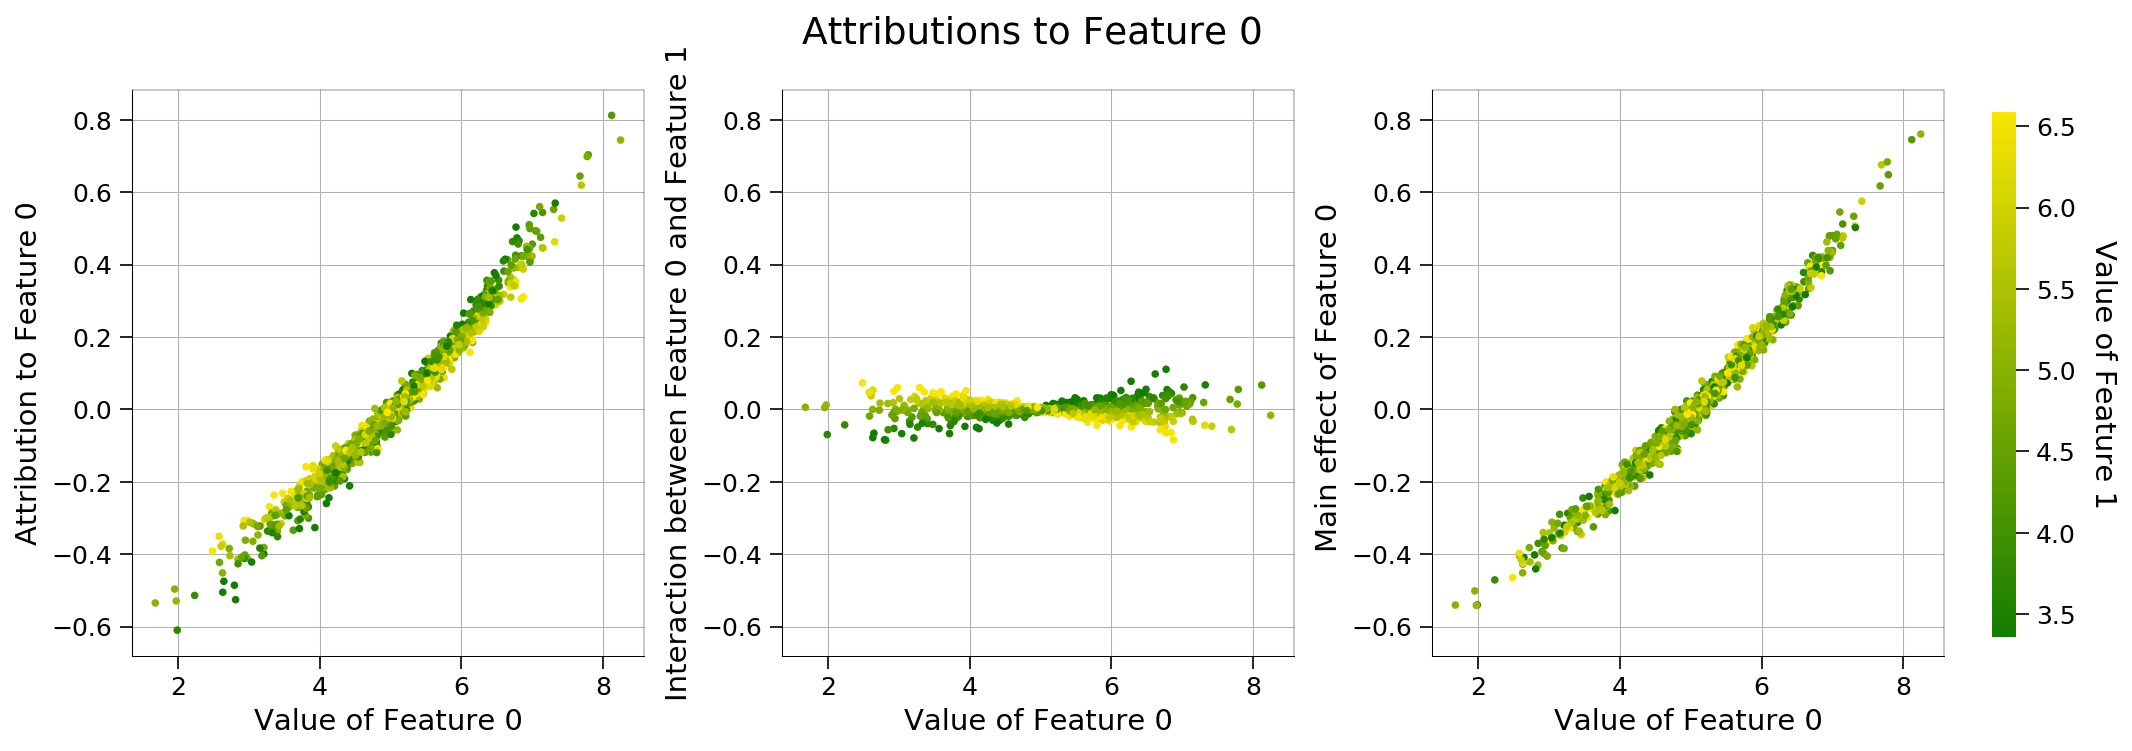

In [195]:
fig, axs = scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

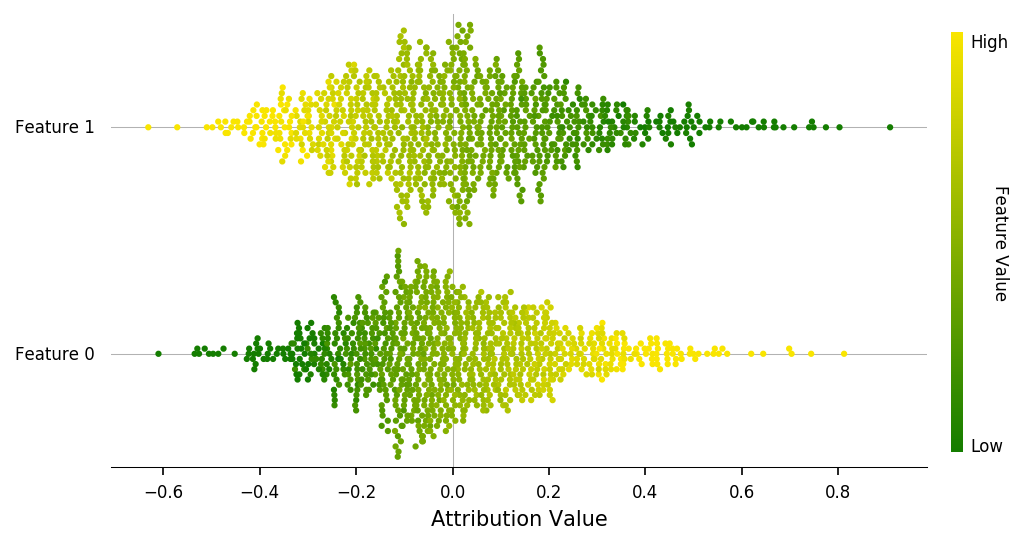

In [196]:
summary_plot(attributions,
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

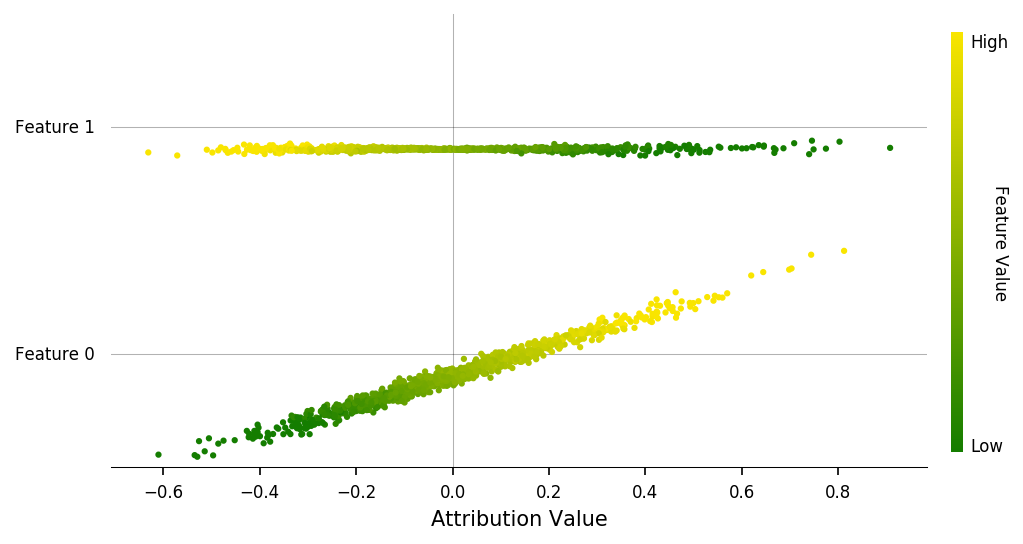

In [197]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

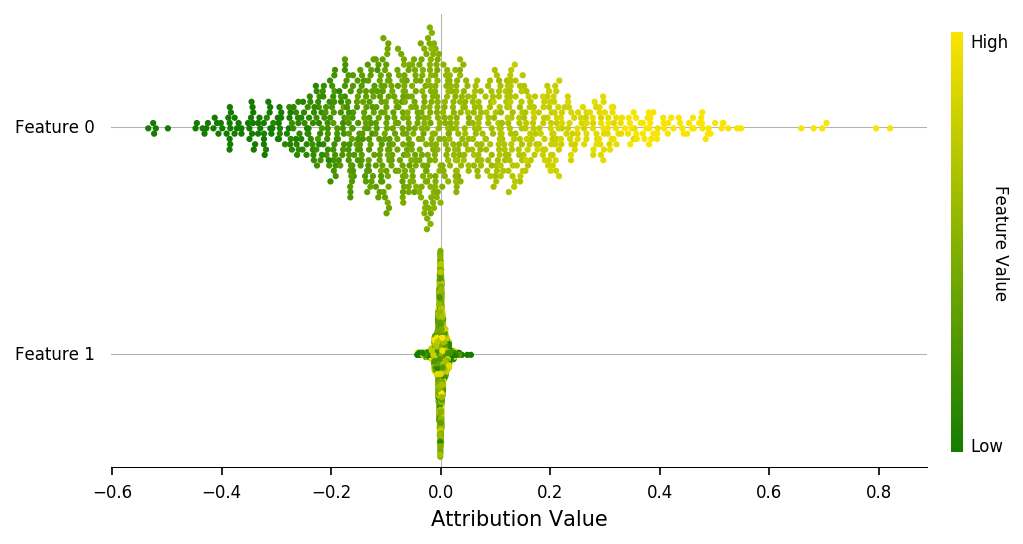

In [198]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)